In [1]:
%pylab inline

import tensorflow as tf
import tensorflow.keras as keras
import requests
import pandas as pd
import pandas_datareader as pdr

from datetime import datetime

rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [66]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

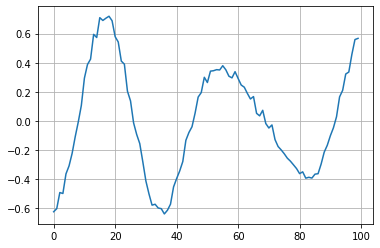

In [67]:
plot(generate_time_series(1,100).flatten())

In [13]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000,:n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000,:n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:,:n_steps], series[9000:, -1]

In [15]:
# Baseline
y_pred = X_valid[:,-1]
print('naive mse: {:0.4f}'.format(np.mean(keras.losses.mean_squared_error(y_valid, y_pred))))

naive mse: 0.0201


In [49]:
# Basic fully connected network
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(50,1)),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(X_train, y_train, batch_size=700, epochs=20, validation_data=(X_valid, y_valid), verbose=0)

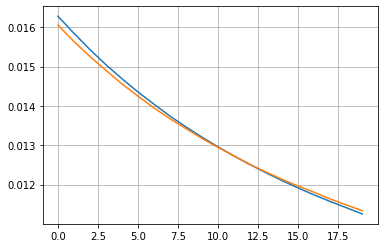

In [45]:
plot(history.history['loss'])
plot(history.history['val_loss'])

In [48]:
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model2.fit(X_train, y_train, batch_size=700, epochs=20, validation_data=(X_valid, y_valid), verbose=0)

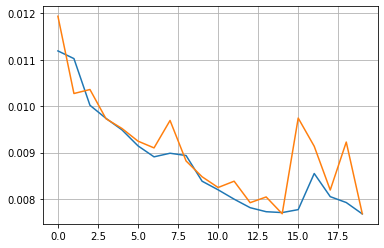

In [53]:
plot(history.history['loss'])
plot(history.history['val_loss'])

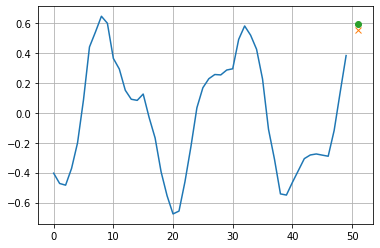

In [68]:
plot(X_test[0])
plot([51],y_test[0],'x')
plot([51],model2.predict(X_test[0].reshape(1,50,1)),'o')

In [110]:
# Coinbase candles, to be used later
btc_data = requests.get('https://api.pro.coinbase.com/products/BTC-USD/candles?granularity=21600').json()
btc_data = pd.DataFrame(btc_data,columns=['time','low','high','open','close','volume'])[::-1]
btc_data.time = list(map(datetime.fromtimestamp, btc_data.time))

In [2]:
btc = pdr.get_data_yahoo('BTC-USD').Close

In [45]:
dataset_size = len(btc)//8

In [243]:
#X = np.array([btc.values[pt:][:7].reshape(7,1)/btc.values[pt:][0]-1 for pt in start_pts])
X = np.array([(btc.values[pt+1:][:6]/btc.values[pt:][:6]-1).reshape(6,1) for pt in start_pts])
y = np.array([[btc.values[pt:][7]]/btc.values[pt:][6]-1 for pt in start_pts])

In [244]:
train_idx = np.random.randint(len(X),size=(200))
X_train = X[train_idx,:]
y_train = y[train_idx,:]
X_test  = X[~train_idx,:]
y_test  = y[~train_idx,:]

In [245]:
def custom_loss(y_actual, y_pred):
    return tf.reduce_mean(-(y_actual*y_pred))

model3 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1,activation='sigmoid')
])
model3.compile(optimizer='adam', loss='mse')
model3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_27 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_28 (SimpleRNN)    (None, 20)                820       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [246]:
history = model3.fit(X_train,y_train,batch_size=20,epochs=10,validation_data=(X_test,y_test),verbose=0)

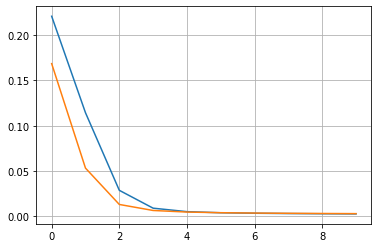

In [247]:
plot(history.history['loss'])
plot(history.history['val_loss'])

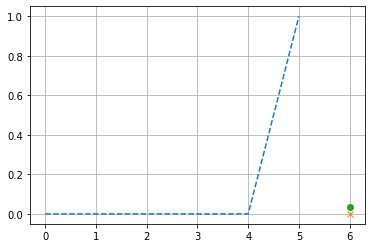

In [251]:
idx = np.random.randint(len(X_test))
plot(X_test[idx]>0,'--')
plot([6],y_test[idx]>0,'x')
plot([6],model3.predict(X_test[idx].reshape(1,6,1)),'o')

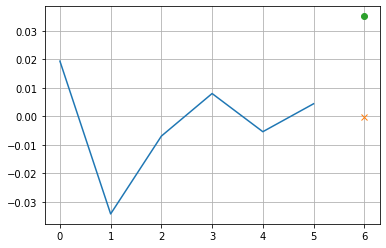

In [252]:
idx = np.random.randint(len(X_test))
plot(X_test[idx])
plot([6],y_test[idx],'x')
plot([6],model3.predict(X_test[idx].reshape(1,6,1)),'o')

In [253]:
sign = (model3.predict(X_test)*y_test)

In [254]:
len(sign[sign > 0])/len(sign)

0.535

In [255]:
model3.predict(X_test).mean()

0.035039745

In [256]:
y_test.mean()

-0.0009880447216441151